# Network analysis of US domestic flight dataset

## Notebook setup

This notebook is a network analysis of US domestic flight data using networkx, cartopy and matplotlib packages to create a network visualisation. The following versions were used in notebook setup.

Python = 3.12.6

cartopy = 0.23.0  
matplotlib = 3.9.2  
networkx = 3.3  
numpy = 2.1.1  
pandas = 2.2.3  





In [11]:
import pandas as pd
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs 
import cartopy.feature as cfeature

Matplotlib is building the font cache; this may take a moment.


## Read and prepare data

In [7]:
# Airport data
airports_headers = ['iata', 'name', 'city', 'state', 'country', 'latitude', 'longitude']
airports = pd.read_csv('airports.csv', names = airports_headers)

# Flights data
flights = pd.read_csv('flights-airport.csv')

Check that the flights 'origins' and 'destinations' have the same code as airports 'iata'. The datatype 'set' only holds unique values so we can use this to check.


In [8]:
origin = flights['origin'].unique() 
destination = flights['destination'].unique()
flights_set = set(np.append(origin, destination)) # create one long, unique array
airports_set = set(airports['iata'])
flights_set.issubset(airports_set) # airports will be a bigger array than flights

True

In [9]:
# Create a list of airports
val = airports['iata'].to_list()
# Index the airports
indx = pd.Index(val)
indx

Index(['00R', '00V', '01G', '01J', '01M', '02A', '02C', '02G', '03D', '04M',
       ...
       'Z55', 'Z73', 'Z84', 'Z91', 'Z95', 'ZEF', 'ZER', 'ZPH', 'ZUN', 'ZZV'],
      dtype='object', length=3375)

In [10]:
# Insert new columns to show flights from and to
flights.insert(1, 'Name Origin', airports.loc[indx.get_indexer(flights['origin']), 'name'].values)
flights.insert(3, 'Name Destination', airports.loc[indx.get_indexer(flights['destination']), 'name'].values)

flights.to_csv('new_flights.csv', index = False, header = True) # save a copy
flights.head()

,origin,Name Origin,destination,Name Destination,count
0,ABE,Lehigh Valley International,ATL,William B Hartsfield-Atlanta Intl,853
1,ABE,Lehigh Valley International,BHM,Birmingham International,1
2,ABE,Lehigh Valley International,CLE,Cleveland-Hopkins Intl,805
3,ABE,Lehigh Valley International,CLT,Charlotte/Douglas International,465
4,ABE,Lehigh Valley International,CVG,Cincinnati Northern Kentucky Intl,247


## Create a plot
Using networkx with matplotlib to visualise the graph G(V,E) - G for graph, V for vertices, and E for edges.

* Actors (vertices): airports
* Relations (edges): routes between airports (iata codes). The strength of the edges will be determined by number of flights

Some of these airports will be hubs with many connections. Others may be small and not connected to any hubs.

networkx spring_layout is a force-directed graph, used to visualise a lot of vertices. Each vertex and each edge is on a spring, the vertices are being forced apart but the edges are being forced to be more or less the same length. It will try and reach an equilibrium between pushing the nodes apart, keeping the edges the same length whilst staying in the right position on the map.

In [13]:
G = nx.from_pandas_edgelist(flights,
                           source = 'origin',
                           target = 'destination',
                           edge_attr = 'count',
                           create_using = nx.Graph())
G

In [15]:
# list the connected components (sub-graphs of airport networks) and pass them to a sub-graph
sg = next(G.subgraph(c) for c in nx.connected_components(G))

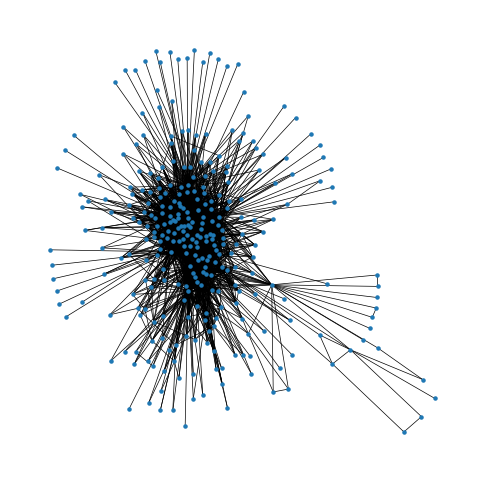

In [16]:
# draw the spring-layout graph 
fig, ax = plt.subplots(1, 1, figsize = (6, 6)) # using subplots function as we will be drawing a number of graphs; 1,1 refers to the position
nx.draw_networkx(sg, ax = ax, with_labels = False, # ax=ax - the axis will just be the axis of the subplot
                node_size = 5, width = .5)
ax.set_axis_off() # no x and y axis

Now we have drawn our graph as a spring-graph. Next we will impose this onto a map, to do so we will need some positions.

In [17]:
# create a dictionary of the lat and longitudes for each iata
pos = {}

for index, row in airports.iterrows():
    # check for repeats
    if not row['iata'] in airports:
        pos[row['iata']] = (row['longitude'], row['latitude'])

In [18]:
# For each vertex, create a dictionary of the number of routes per airport.
deg = nx.degree(sg) 
sizes = [5 * deg[iata] for iata in sg.nodes] # iterate through and multiply each by 5 to help with plotting

In [19]:
# Create dictionary of labels. If label size > 20 then we give it a name - i.e. only plot the major airports.
labels = {iata: iata if deg[iata] >= 20 else ''
         for iata in sg.nodes}

/Users/jackwalker/anaconda3/envs/network/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1683: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


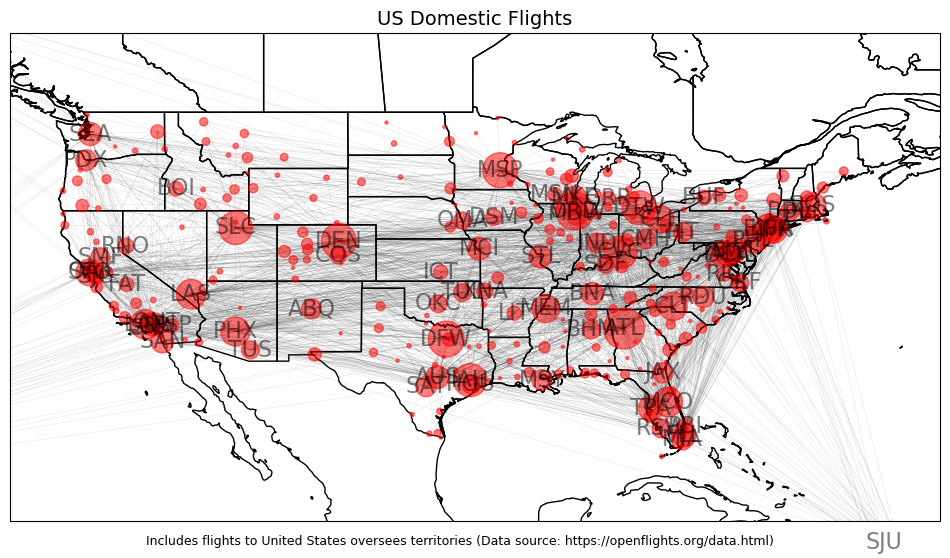

In [20]:
# Map projection 

# World map
crs = ccrs.PlateCarree() # PlateCarree is the projection we are using, built on top of matplotlib
fig, ax = plt.subplots(
    1, 1, figsize = (12, 8), # position row 1, column 1
    subplot_kw = dict(projection = crs)) # subplot_kw takes a dictionary and defines the type of projection we will be using
ax.coastlines() # only view the coastlines

# specify where in the world we want to view - USA
ax.set_extent([-128, -62, 20, 50]) # this is the lat and longs for the USA
ax.add_feature(cfeature.STATES) # add the States

# add a title and caption to the plot
plt.title("US Domestic Flights", fontsize = 14)
txt="Includes flights to United States oversees territories (Data source: https://openflights.org/data.html)"
plt.figtext(0.5, 0.16, txt, horizontalalignment='center', fontsize=9)

# now we project on our networkx graph. We will use the long and lats to plot correctly.
nx.draw_networkx(sg, ax = ax,
                font_size = 16,
                alpha = .5,
                width = .075,
                node_size = sizes,
                labels = labels,
                pos = pos,
                node_color = 'red',
                cmap = plt.cm.autumn,
                )

# if you remove the set_extent line it will show the whole world and you cans ee the flights to other USA territories


In [21]:
fig.savefig('US-Flights.png') # save the plot as a png